**GOALS**:
- Discover techniques to process imbalanced data.
- Explore data with more care.
- Start to develop metrics and function to evaluate and tune models.
- Feature selection (because treating all NaN adequately would take a long time -- 7xx features...)

**Table of contents**<a id='toc0_'></a>    
- 1. [Get some data](#toc1_)    
- 2. [Plotting individuals in the income/credit plan](#toc2_)    
- 3. [Addressing the class imbalance : under/oversampling & SMOTE](#toc3_)    
- 4. [Threshold moving](#toc4_)    
- 5. [Metrics experimentation](#toc5_)    
- 6. [Feature selection](#toc6_)    
  - 6.1. [Univariate filtering with the target followed by correlation](#toc6_1_)    
  - 6.2. [Intrinsic : With LightGBM feature importance](#toc6_2_)    
- 7. [Imputing selected features](#toc7_)    
  - 7.1. [EDA](#toc7_1_)    
- 8. [Fine-tuning a classifier](#toc8_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [8]:
import gc

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import utils
import config
import colorcet as cc
import missingno as msno

from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
)

from sklearn.feature_selection import (
    SelectKBest,
    chi2,
    f_classif,
    mutual_info_classif,
 )

from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler   
from imblearn.pipeline import Pipeline

import lightgbm as lgb




# 1.  [&#9650;](#toc0_) <a id='toc1_'></a>Get some data

In [2]:
#Pick a number of individuals for faster results.
n_indiv = 5_000

In [3]:
# Get the features and target of individuals with a target.
X, y = utils.prepare_data(config.FEATURE_PATH)

Data shape: (307506, 41), target shape: (307506,)


In [6]:
# down-sample
X = X.sample(n_indiv)
y = y.loc[X.index]

display(X.head())
display(y.head())

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,...,AGE_RANGE,CREDIT_TO_INCOME_RATIO,INCOME_TO_BIRTH_RATIO,ID_TO_BIRTH_RATIO,CREDIT_TO_ANNUITY_GROUP,GROUP2_EXT_SOURCES_MEDIAN,GROUP2_INCOME_MEDIAN,GROUP2_CREDIT_TO_ANNUITY_MEDIAN,GROUP2_CREDIT_MEDIAN,GROUP2_ANNUITY_MEDIAN
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
342387,0,1,0,0,162000.0,942300.0,0,0,3,0,...,4,5.816406,-8.562500,0.130737,6,0.529785,144000.0,34.000000,900693.0,27760.5
366497,0,1,0,0,189000.0,942300.0,3,1,0,0,...,4,4.984375,-8.320312,0.200439,6,0.588867,157500.0,32.843750,814041.0,26086.5
310036,0,0,0,0,315000.0,791595.0,0,0,1,0,...,3,2.513672,-20.343750,0.240356,4,0.487549,135000.0,20.000000,450000.0,22018.5
224943,0,0,1,0,157500.0,450000.0,0,0,1,0,...,1,2.857422,-17.062500,0.204834,4,0.487549,135000.0,20.000000,450000.0,22018.5
345128,0,0,1,2,247500.0,509400.0,2,0,1,0,...,3,2.058594,-16.515625,0.278076,3,0.500488,157500.0,14.710938,397881.0,27193.5


SK_ID_CURR
342387    0.0
366497    0.0
310036    0.0
224943    0.0
345128    0.0
Name: TARGET, dtype: float16

In [7]:
# check imbalance mostly preserved
y.value_counts()

TARGET
0.0    4560
1.0     440
Name: count, dtype: int64

In [8]:
X_no_nan = X.dropna(axis=1)
X_no_nan.shape

(5000, 41)

Dropping all columns with nulls is losing a consequent part of information.
Imputation will probably be required for some models.

In [9]:
X_no_nan.head()

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,...,AGE_RANGE,CREDIT_TO_INCOME_RATIO,INCOME_TO_BIRTH_RATIO,ID_TO_BIRTH_RATIO,CREDIT_TO_ANNUITY_GROUP,GROUP2_EXT_SOURCES_MEDIAN,GROUP2_INCOME_MEDIAN,GROUP2_CREDIT_TO_ANNUITY_MEDIAN,GROUP2_CREDIT_MEDIAN,GROUP2_ANNUITY_MEDIAN
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
342387,0,1,0,0,162000.0,942300.0,0,0,3,0,...,4,5.816406,-8.562500,0.130737,6,0.529785,144000.0,34.000000,900693.0,27760.5
366497,0,1,0,0,189000.0,942300.0,3,1,0,0,...,4,4.984375,-8.320312,0.200439,6,0.588867,157500.0,32.843750,814041.0,26086.5
310036,0,0,0,0,315000.0,791595.0,0,0,1,0,...,3,2.513672,-20.343750,0.240356,4,0.487549,135000.0,20.000000,450000.0,22018.5
224943,0,0,1,0,157500.0,450000.0,0,0,1,0,...,1,2.857422,-17.062500,0.204834,4,0.487549,135000.0,20.000000,450000.0,22018.5
345128,0,0,1,2,247500.0,509400.0,2,0,1,0,...,3,2.058594,-16.515625,0.278076,3,0.500488,157500.0,14.710938,397881.0,27193.5


In [10]:
y.head()

SK_ID_CURR
342387    0.0
366497    0.0
310036    0.0
224943    0.0
345128    0.0
Name: TARGET, dtype: float16

# 2.  [&#9650;](#toc0_) <a id='toc2_'></a>Plotting individuals in the income/credit plan

In [11]:
def display_2d_with_illustrative_var(
    X,
    ax=None,
    figsize=(7,7),
    illustrative_var=None,
    alpha=0.7,
    palette=None,
    title=None,
):
    """ Display points in a plan with color for each class of illustrative var.

    X : dataframe with 2 cols (x, y)
    illustrative_var : list of length len(X) containing classes.
    """
    # Boolean which automates plt.show() if no ax is provided.
    final_plot = False
    if ax is None:
        fig, ax= plt.subplots(figsize=figsize)
        final_plot = True

    # Display the points
    if illustrative_var is None:
        ax.scatter(X[:, 0], X[:, 1], s=10, alpha=alpha)
    else:
        illustrative_var = np.array(illustrative_var)
        illustrative_values = np.unique(illustrative_var)
        n_val = len(illustrative_values)
        if palette is None:
            palette = sns.color_palette(cc.glasbey, n_val)
        # Plot reversely to see most frequent on top.
        for n, value in enumerate(illustrative_values):
            selected = np.where(illustrative_var == value)
            ax.scatter(
                X[selected, 0], X[selected, 1],
                alpha=alpha, label=value, color=palette[n_val - 1 - n],
                s=10
            )
        # ax.set_axis_off()
        if title is not None:
            ax.set_title(title)
        ax.legend(bbox_to_anchor=(1.05, 1),
                    loc='upper left',
                    borderaxespad=0.,
                    fontsize=10)
        
        if final_plot:
            plt.show()
    return None

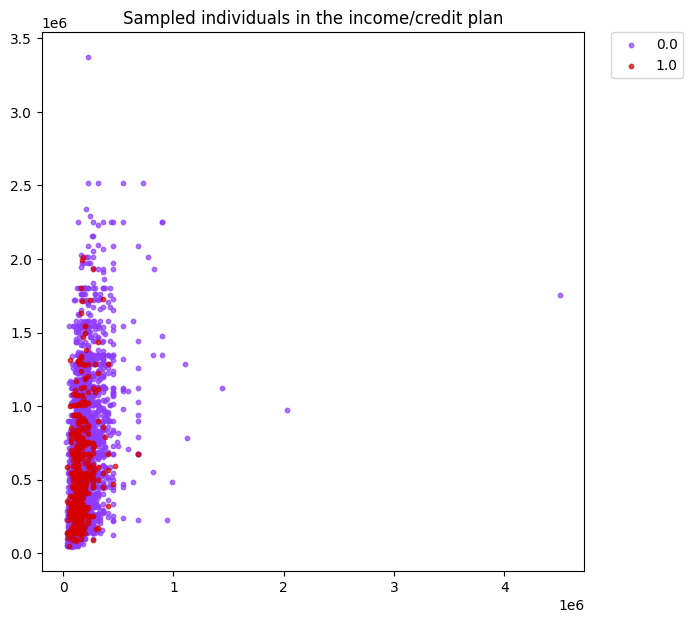

In [12]:
sel_fts = ['AMT_INCOME_TOTAL', 'AMT_CREDIT']
display_2d_with_illustrative_var(
    X_no_nan.loc[:, sel_fts].values,
    illustrative_var=y.values,
    title='Sampled individuals in the income/credit plan'
)



Although no visual difference strikes, it will help to illustrate the impact of imbalance class processing.

# 3.  [&#9650;](#toc0_) <a id='toc3_'></a>Addressing the class imbalance : under/oversampling & SMOTE

SMOTE main advantage : Help decreasing over-fitting while introducing synthetic individuals with some kind of interpolation .

Sources :
- [to understand SMOTE algorithm](https://kobia.fr/imbalanced-data-smote/)
- [some examples and tips](https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/).

 It is pointed out that the original paper on SMOTE suggests combining SMOTE with random undersampling of the majority class.

Important things:
- SMOTE must not be applied on encoded categorical variables (which we have)
- SMOTE must not be applied on test and validation set (Evaluation would be unrealistic)
- SMOTE works better after feature normalization (because based on distances)
- SMOTE need hyperparameter tuning (because synthetic individuals can be wrongly introduced depending on the minority distribution)
- if SMOTE is applied on discrete features, the algorithm will introduce new intermediate values that must then be mapped to the original values.

Conclusion :

It will be interesting to apply that in the final model, but it needs to be done carefully and it will take some time. I'd rather start with a simple under/oversampling of classes first, run some models to assess feature importance and, then only prepare those features to be SMOTE-processed.

In [23]:
# create some minority synthetic individuals to yield a rate indicated in sampling_strategy
over = SMOTE(k_neighbors=5, sampling_strategy=0.4)
# downsample the majority class to something more balanced
under = RandomUnderSampler(sampling_strategy=0.7)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
X_resample, y_resample = pipeline.fit_resample(X_no_nan, y)

In [18]:
X_resample.shape

(4429, 41)

In [22]:
# Resample percentages
y_resample.value_counts()* 100/len(y_resample)

TARGET
0.0    58.816889
1.0    41.183111
Name: count, dtype: float64

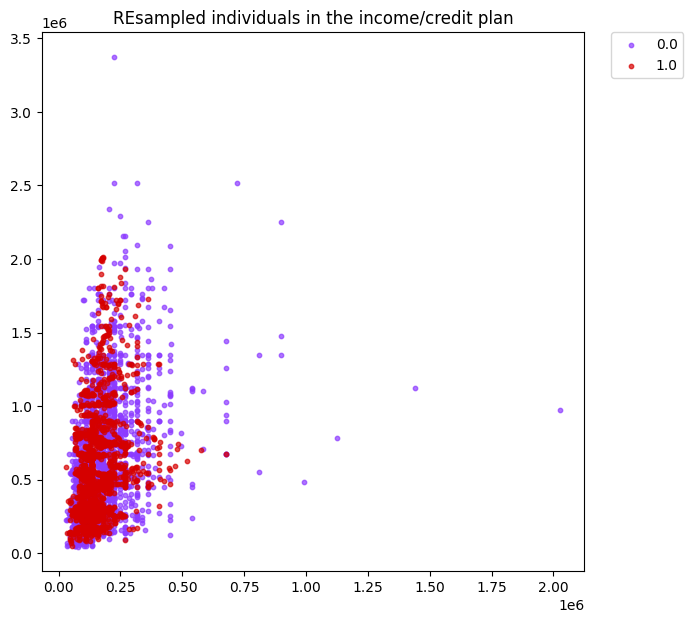

In [20]:
display_2d_with_illustrative_var(
    X_resample.loc[:, sel_fts].values,
    illustrative_var=y_resample.values,
    title='REsampled individuals in the income/credit plan'
)

We yield a much more balanced dataset and synthetic individuals looks natural in that plan. We have a bit less individuals in total but the percentage of the minority class is now closer to 50%. The proportions chosen when up or down sampling certain class will help the classification algorithm to detect properly the minority class. I will have to tune it alongside with the number of neighbors used by SMOTE.

Note that categorical features can be processed with SMOTE-NC

# 4.  [&#9650;](#toc0_) <a id='toc4_'></a>Threshold moving

As stated in this [article](https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/):

    - trying other methods, such as sampling, without trying by simply setting the threshold may be misleading. The threshold-moving method uses the original training set to train [a model] and then moves the decision threshold such that the minority class examples are easier to be predicted correctly.

    How to determine the best threshold?

    1. Fit Model on the Training Dataset.
    2. Predict Probabilities on the Test Dataset.
    3. For each threshold in Thresholds:
        3a. Convert probabilities to Class Labels using the threshold.
        3b. Evaluate Class Labels.
        3c. If Score is Better than Best Score.
            3ci. Adopt Threshold.
        4. Use Adopted Threshold When Making Class Predictions on New Data.

So it is suggested not to adopt sampling at first!

Note : I might want to use this approach inside a CV.


# 5.  [&#9650;](#toc0_) <a id='toc5_'></a>Metrics experimentation

In [2]:
# Define some metrics and scorers


def specificity_score(y_true, y_pred):
    """ Specificity is the recall of the negative class"""
    return recall_score(y_true, y_pred, pos_label=0)


def weighted_geometric_mean_score(y_true, y_pred, recall_weight=5):
    """
    Compute the weighted geometric mean of recall and specificity.
    
    It is the (recall_weight + 1)th root of the product
    (recall^recall_weight * specificity)
    """
    recall = recall_score(y_true, y_pred)
    specificity = specificity_score(y_true, y_pred)
    return np.power(
        np.power(recall, recall_weight) * specificity,
        1 / (recall_weight + 1)   
    )


def loss_of_income_func(y_true, y_pred, fn_weight=5):
    """ Compute the loss of income due to false negatives
    and false positives over-penalizing false negative with a weight. 
    """
    tn, fp, fn, tp = confusion_matrix(**vectors).ravel()
    return fn_weight*fn + fp
   
   
scorers = {
    'accuracy_score': make_scorer(accuracy_score),
    'auc_score': make_scorer(roc_auc_score),
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'f1_score': make_scorer(fbeta_score, beta=1),
    'f2_score': make_scorer(fbeta_score, beta=2),
    'f3_score': make_scorer(fbeta_score, beta=3),
    'geometric_mean_score': make_scorer(geometric_mean_score, average='binary'),
    'weighted_geometric_mean_score': make_scorer(weighted_geometric_mean_score),
    'loss_of_income': make_scorer(loss_of_income_func, greater_is_better=False)
}

In [4]:
from sklearn.metrics import confusion_matrix
configurations = {
    "3fp_1fn":{
        "y_true":[0,0,0,0,0,0,0,0,0,1,1],
        "y_pred":[1,1,0,1,0,0,0,0,0,0,1]    
    },
    "2fp_1fn":{
        "y_true":[0,0,0,0,0,0,0,0,0,1,1],
        "y_pred":[1,1,0,0,0,0,0,0,0,0,1]    
    },
    "1fp_1fn":{
        "y_true":[0,0,0,0,0,0,0,0,0,1,1],
        "y_pred":[1,0,0,0,0,0,0,0,0,0,1]    
    },
    "5fp_1fn":{
        "y_true":[0,0,0,0,0,0,0,0,0,1,1],
        "y_pred":[1,1,1,1,1,0,0,0,0,0,1]    
    },
    "0fp_2fn":{
        "y_true":[0,0,0,0,0,0,0,0,1,1,1],
        "y_pred":[0,0,0,0,0,0,0,0,0,0,1]    
    },
    "3fp_0fn":{
        "y_true":[0,0,0,0,0,0,0,0,0,1,1],
        "y_pred":[1,1,0,1,0,0,0,0,0,1,1]    
    },
    "2fp_0fn":{
        "y_true":[0,0,0,0,0,0,0,0,0,1,1],
        "y_pred":[1,1,0,0,0,0,0,0,0,1,1]    
    },
    "1fp_0fn":{
        "y_true":[0,0,0,0,0,0,0,0,0,1,1],
        "y_pred":[1,0,0,0,0,0,0,0,0,1,1]    
    },
    "0fp_1fn":{
        "y_true":[0,0,0,0,0,0,0,0,0,1,1],
        "y_pred":[0,0,0,0,0,0,0,0,0,0,1]    
    },
}

for conf_name, vectors in configurations.items():
    print(f'\n{conf_name}')
    tn, fp, fn, tp = confusion_matrix(**vectors).ravel()
    print(confusion_matrix(**vectors))
    print(f"recall: {recall_score(**vectors)}")
    print(f"specificity: {specificity_score(**vectors)}")
    print(f"weighted_geometric : {weighted_geometric_mean_score(**vectors)}")
    print(f"f3 : {fbeta_score(**vectors, beta=3)}")
    print(f"f1 : {fbeta_score(**vectors, beta=1)}")
    print(f"loss of income: {loss_of_income_func(**vectors)}")
    


3fp_1fn
[[6 3]
 [1 1]]
recall: 0.5
specificity: 0.6666666666666666
weighted_geometric : 0.5245575317108241
f3 : 0.45454545454545453
f1 : 0.3333333333333333
loss of income: 8

2fp_1fn
[[7 2]
 [1 1]]
recall: 0.5
specificity: 0.7777777777777778
weighted_geometric : 0.538208962275686
f3 : 0.47619047619047616
f1 : 0.4
loss of income: 7

1fp_1fn
[[8 1]
 [1 1]]
recall: 0.5
specificity: 0.8888888888888888
weighted_geometric : 0.5503212081491045
f3 : 0.5
f1 : 0.5
loss of income: 6

5fp_1fn
[[4 5]
 [1 1]]
recall: 0.5
specificity: 0.4444444444444444
weighted_geometric : 0.49028045890548
f3 : 0.41666666666666663
f1 : 0.25
loss of income: 10

0fp_2fn
[[8 0]
 [2 1]]
recall: 0.3333333333333333
specificity: 1.0
weighted_geometric : 0.40031231839200093
f3 : 0.3571428571428571
f1 : 0.5
loss of income: 10

3fp_0fn
[[6 3]
 [0 2]]
recall: 1.0
specificity: 0.6666666666666666
weighted_geometric : 0.9346552651840672
f3 : 0.8695652173913044
f1 : 0.5714285714285715
loss of income: 3

2fp_0fn
[[7 2]
 [0 2]]
rec

Loss of income is what the client truly wants to optimize.

# 6.  [&#9650;](#toc0_) <a id='toc6_'></a>Feature selection

A wide variety of feature selection algorithms exist.
- univariate statistic between each input and the output.
- evaluation of correlation between inputs (to avoid colinearity problems)
- intrinsic selection (some models such as lasso, or decision trees naturally perform feature selection).

Here, is a table showing how to compute statistics between variable types.


<img src="https://machinelearningmastery.com/wp-content/uploads/2019/11/How-to-Choose-Feature-Selection-Methods-For-Machine-Learning.png" width=600 />

I am going to test two methods :
- univariate followed by correlation.
- intrinsic with lightGBM classifier.

## 6.1.  [&#9650;](#toc0_) <a id='toc6_1_'></a>Univariate filtering with the target followed by correlation

In [19]:
# Get the features and target of individuals with a target.
X, y = utils.prepare_data(
    config.FEATURE_PATH,
    drop_INF=False,
    drop_NAN=False,
    n_sample=80_000,
)

took only 80000 random samples.
Data shape: (80000, 735), target shape: (80000,)


In [20]:
# Compute max and min per feature
maxs_non_inf = X.replace(np.inf, np.nan).max(axis=0)
mins_non_inf = X.replace(-np.inf, np.nan).min(axis=0)

In [21]:
# Clip -inf and inf values using the min and max (mult by ten)
X_clipped = X.clip(
    lower=mins_non_inf*10,
    upper=maxs_non_inf*10,
    axis=1
)

/home/louberehc/.pyenv/versions/3.11.4/envs/p7/lib/python3.11/site-packages/pandas/core/dtypes/cast.py:1852: RuntimeWarning: overflow encountered in cast
  casted = element.astype(dtype)


In [22]:
# Impute nulls with medians to allow the K best selection (need no nan nor inf)
med_imp = SimpleImputer(missing_values=np.nan, strategy='median')
X_imp = med_imp.fit_transform(X_clipped)

X_imp = pd.DataFrame(
    X_imp,
    index=X.index,
    columns=X.columns,
)
# Split into numerical and categorical features.
categorical_feature = [
    'CODE_GENDER', 'FLAG_OWN_CAR', 'NAME_CONTRACT_TYPE',
    'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
    'NAME_INCOME_TYPE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE',
    'WEEKDAY_APPR_PROCESS_START'
]

numerical_feature = [ft for ft in X.columns 
                     if ft not in categorical_feature]

X_cat = X_imp.loc[:, categorical_feature]
X_num = X_imp.loc[:, numerical_feature]


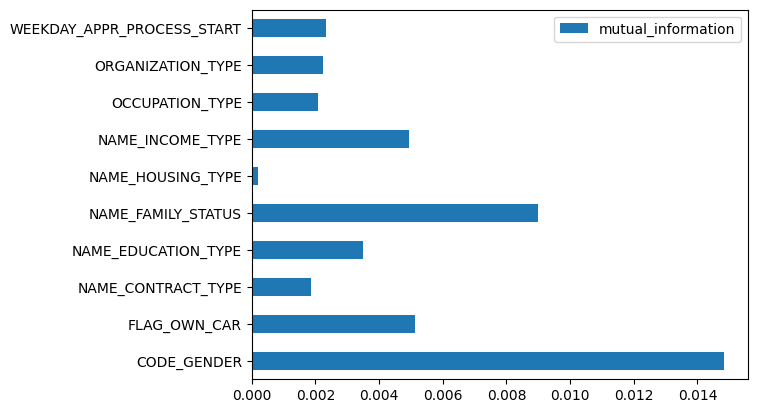

In [30]:
# Compute univariate statistics depending on the variable type.
MI_score = pd.DataFrame(
    mutual_info_classif(X_cat, y),
    index=list(X_cat.columns),
    columns=['mutual_information']
)

MI_score.plot(kind='barh')
plt.show()

5 categorical features share significantly more information with the target

/home/louberehc/.pyenv/versions/3.11.4/envs/p7/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  6  13  14  73  81  91  93  95  96  97  99 101 102 103 106 110 544 634
 642 643 644 648 649 650] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/louberehc/.pyenv/versions/3.11.4/envs/p7/lib/python3.11/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


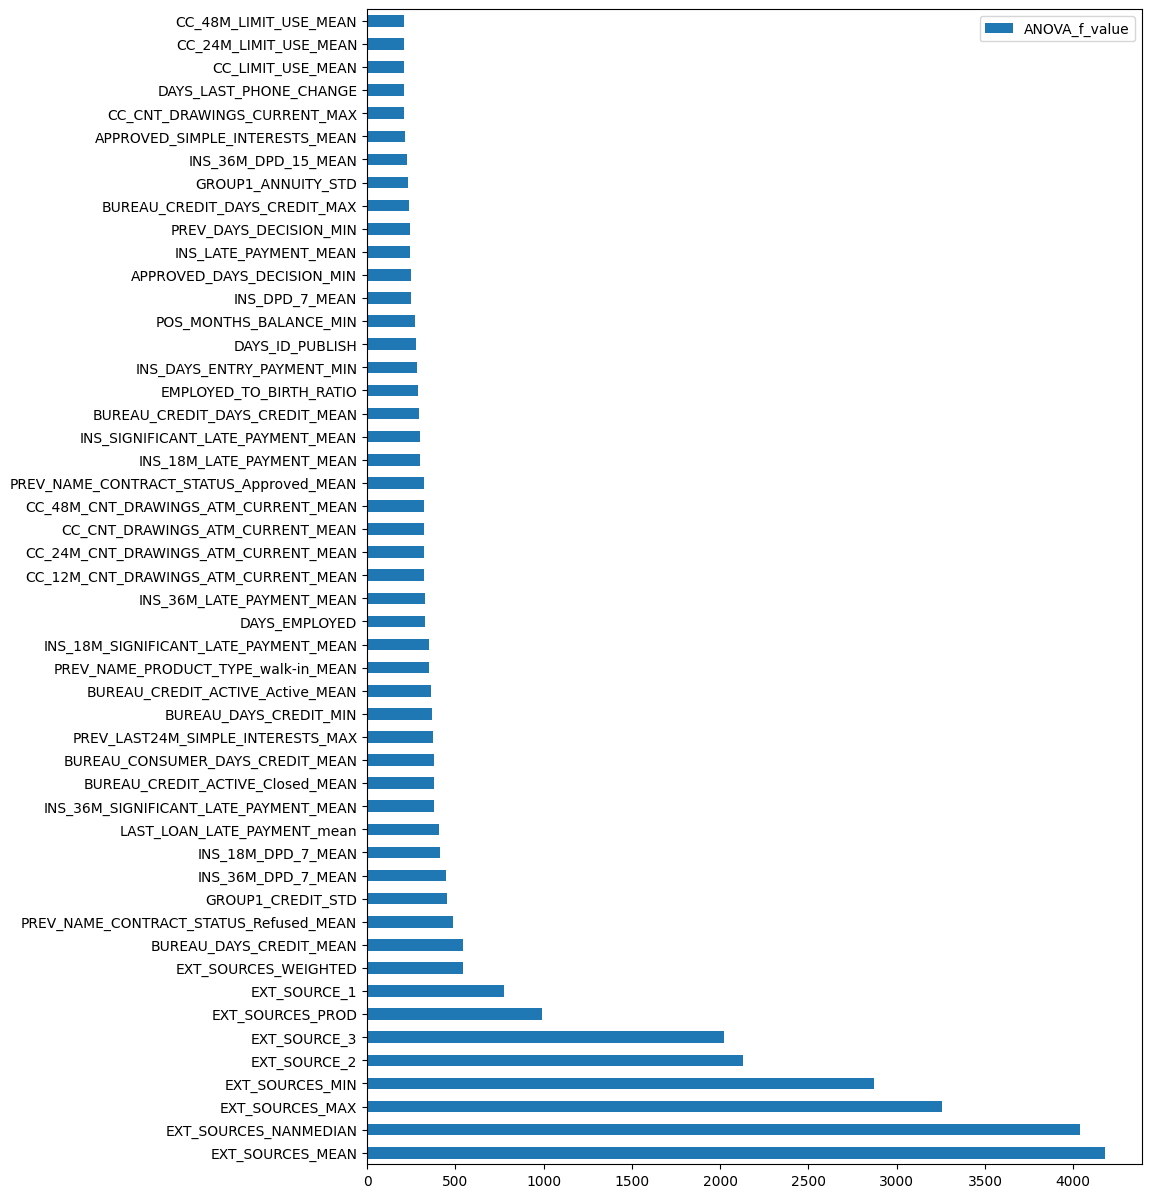

In [31]:
f_val, _ = f_classif(X_num, y)

ANOVA_score = pd.DataFrame(
    f_val,
    index=list(X_num.columns),
    columns=['ANOVA_f_value']
)

ANOVA_score.sort_values('ANOVA_f_value', ascending=False).head(50).plot(kind='barh', figsize=(10,15))
plt.show()

The ANOVA shows ext_sources based features are probably the most important.

For the other, the f_value is not significantly different.

In [32]:
ANOVA_score.to_csv('ANOVA_score.csv.gz')
MI_score.to_csv('MI_score.csv.gz')

## 6.2.  [&#9650;](#toc0_) <a id='toc6_2_'></a>Intrinsic : With LightGBM feature importance

It is the model used in the kernel I used for feature extraction. Thus, features are already well prepared to go inside the model. And It can handle missing values with internal mechanism.

A note from the [documentation](https://lightgbm.readthedocs.io/en/stable/Python-Intro.html):
- LightGBM can use categorical features as input directly. It doesn’t need to convert to one-hot encoding, and is much faster than one-hot encoding (about 8x speed-up).
Note: You should convert your categorical features to int type before you construct Dataset.


 Below, the feature importance is computed as the mean of the feature importance found in 5 models trained on different fold combinations where the training dataset was over/undersampled to yield an almost balanced dataset. The validation dataset stayed in its original proportions.

In [66]:
# Get the features and target of individuals with a target.
X, y = utils.prepare_data(
    config.FEATURE_PATH,
    drop_INF=False,
    drop_NAN=False,
    n_sample=50_000,
)
X = utils.rename_col_for_lgbm_compatibility(X)

took only 50000 random samples.
Data shape: (50000, 735), target shape: (50000,)


In [67]:
# Split in a train and test sets.
# I will use the train set for cross_validation.
train_df, test_df, y_train, y_test = utils.split_data(X, y)

Train shapes : (40000, 735), (40000,)
Test shapes : (10000, 735), (10000,)


In [68]:
for y_ in ['y_train', 'y_test']:
    print(f'In the {y_.removeprefix("y_")} set:')
    utils.class_percentages(eval(y_))
    

In the train set:


TARGET
0.0    91.795
1.0     8.205
Name: count, dtype: float64

In the test set:


TARGET
0.0    91.8
1.0     8.2
Name: count, dtype: float64

In [69]:
# define LightGBM configuration
LIGHTGBM_PARAMS = {
    'boosting_type': 'goss',
    'objective': 'binary',
    'n_estimators': 10000,
    'learning_rate': 0.005,
    'num_leaves': 30,
    'max_depth': 10,
    # 'subsample_for_bin': 240000,
    'reg_alpha': 0.5,
    'reg_lambda': 0.5,
    'colsample_bytree': 0.5,
    # 'min_split_gain': 0.02,
    'subsample': 1,
    # 'is_unbalance': True, <-- no need if taken care with sampling
    # 'silent':1,
    # 'verbose':1
}

# List categorical features for LightGBM partitioning mechanism (Fisher 1958)
categorical_feature = [
    'CODE_GENDER', 'FLAG_OWN_CAR', 'NAME_CONTRACT_TYPE',
    'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
    'NAME_INCOME_TYPE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE',
    'WEEKDAY_APPR_PROCESS_START'
]


clf = lgb.LGBMClassifier(**LIGHTGBM_PARAMS)


In [70]:
# Define imblearn pipeline to be used on the training folds of the CV
# without SMOTE because it would be to much of a chore on 7xx features
over = RandomOverSampler(sampling_strategy=0.5)
under = RandomUnderSampler(sampling_strategy=0.8)
steps = [('o', over), ('u', under)]
resample_pipe = Pipeline(steps=steps)

In [72]:
# Define folds
folds = StratifiedKFold(
    n_splits=config.NUM_FOLDS,
    shuffle=True,
    random_state=config.RANDOM_SEED
)

# Array to receive, per split, prediction of the validation set (out of fold).
oof_preds = np.zeros(train_df.shape[0])
# Some other variables to hold results.
sub_preds = np.zeros(test_df.shape[0])
importance_df = pd.DataFrame()
auc_df = dict()

for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df, y_train)):
    print(f"\n\n##############################\n split {n_fold + 1}")
    train_x, train_y = train_df.iloc[train_idx], y_train.iloc[train_idx]
    valid_x, valid_y = train_df.iloc[valid_idx], y_train.iloc[valid_idx]
    
    # Resample the train set and check the balance
    train_x_resample, train_y_resample = resample_pipe.fit_resample(train_x, train_y)
    print("\n Class percentage in the training folds")
    utils.class_percentages(train_y_resample)
    print("\n Class percentage in the validation fold")
    utils.class_percentages(valid_y)
    
    # Fit the classifier on the resample training set.
    clf.fit(
        train_x_resample, train_y_resample,
        eval_set=[(train_x, train_y), (valid_x, valid_y)],
        eval_names=['training', 'validation'],
        eval_metric=['auc'],
        categorical_feature=categorical_feature,
        callbacks=[lgb.early_stopping(100, first_metric_only=True)],
    )

    best_iter = clf.best_iteration_
    # Partially filling oof_preds
    oof_preds[valid_idx] = clf.predict_proba(
        valid_x,
        num_iteration=best_iter
    )[:, 1]
    # Progressively compute the mean prediction on the test set
    sub_preds += clf.predict_proba(
        test_df,
        num_iteration=best_iter
    )[:, 1] / folds.n_splits

    # Feature importance by GAIN and SPLIT
    fold_importance = pd.DataFrame()
    fold_importance["feature"] = train_df.columns
    fold_importance["gain"] = (
        clf.booster_.feature_importance(importance_type='gain')
    )
    fold_importance["split"] = (
        clf.booster_.feature_importance(importance_type='split')
    )
    importance_df = pd.concat([importance_df, fold_importance], axis=0)
    
    # Save metric value for each iteration in train and validation sets
    auc_df['train_{}'.format(n_fold+1)]  = clf.evals_result_['training']['auc']
    auc_df['valid_{}'.format(n_fold + 1)] = clf.evals_result_['validation']['auc']

    print(
        'Fold %2d AUC : %.4f'
        % (
            n_fold + 1,
            roc_auc_score(valid_y, oof_preds[valid_idx])
        )
    )




##############################
 split 1

 Class percentage in the training folds


TARGET
0.0    55.554547
1.0    44.445453
Name: count, dtype: float64


 Class percentage in the validation fold


TARGET
0.0    91.8
1.0     8.2
Name: count, dtype: float64

[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 14687, number of negative: 18358
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.077974 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141112
[LightGBM] [Info] Number of data points in the train set: 33045, number of used features: 735
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Found 

TARGET
0.0    55.554547
1.0    44.445453
Name: count, dtype: float64


 Class percentage in the validation fold


TARGET
0.0    91.8
1.0     8.2
Name: count, dtype: float64

[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 14687, number of negative: 18358
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.281207 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 141309
[LightGBM] [Info] Number of data points in the train set: 33045, number of used features: 735
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM int

TARGET
0.0    55.554547
1.0    44.445453
Name: count, dtype: float64


 Class percentage in the validation fold


TARGET
0.0    91.8
1.0     8.2
Name: count, dtype: float64

[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 14687, number of negative: 18358
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.319195 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 141274
[LightGBM] [Info] Number of data points in the train set: 33045, number of used features: 735
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM int

TARGET
0.0    55.554547
1.0    44.445453
Name: count, dtype: float64


 Class percentage in the validation fold


TARGET
0.0    91.7875
1.0     8.2125
Name: count, dtype: float64

[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 14687, number of negative: 18358
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.288671 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 141162
[LightGBM] [Info] Number of data points in the train set: 33045, number of used features: 735
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM int

TARGET
0.0    55.554547
1.0    44.445453
Name: count, dtype: float64


 Class percentage in the validation fold


TARGET
0.0    91.7875
1.0     8.2125
Name: count, dtype: float64

[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 14687, number of negative: 18358
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.276897 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 141373
[LightGBM] [Info] Number of data points in the train set: 33045, number of used features: 735
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM int

In [77]:
print(
    'Full AUC score (out of fold concatenation): %.6f'
    % roc_auc_score(y_train, oof_preds)
)
# test_df['TARGET'] = sub_preds.copy()

# Get the average feature importance between folds
mean_importance = importance_df.groupby('feature').mean()
mean_importance.to_csv('mean_feature_importance.csv.gz')

Full AUC score (out of fold concatenation): 0.778958


In [85]:
def display_feature_importance(mean_importance, n_fts = 30):
    mean_importance_gain = (
        mean_importance
        .sort_values(by='gain')
        .loc[:, 'gain']
        .tail(n_fts)
    )

    mean_importance_split = (
        mean_importance
        .sort_values(by='split')
        .loc[:, 'split']
        .tail(n_fts)
    )

    fig, ax = plt.subplots(2,1, figsize=(12, n_fts/2))
    mean_importance_gain.plot(kind='barh', ax=ax[0], title='Feature importance on gain\n Computed on 50 000 samples')
    mean_importance_split.plot(kind='barh', ax=ax[1], title='Feature importance on split\n Computed on 50 000 samples')
    plt.show()
    return list(mean_importance_gain.index), list(mean_importance_split.index)

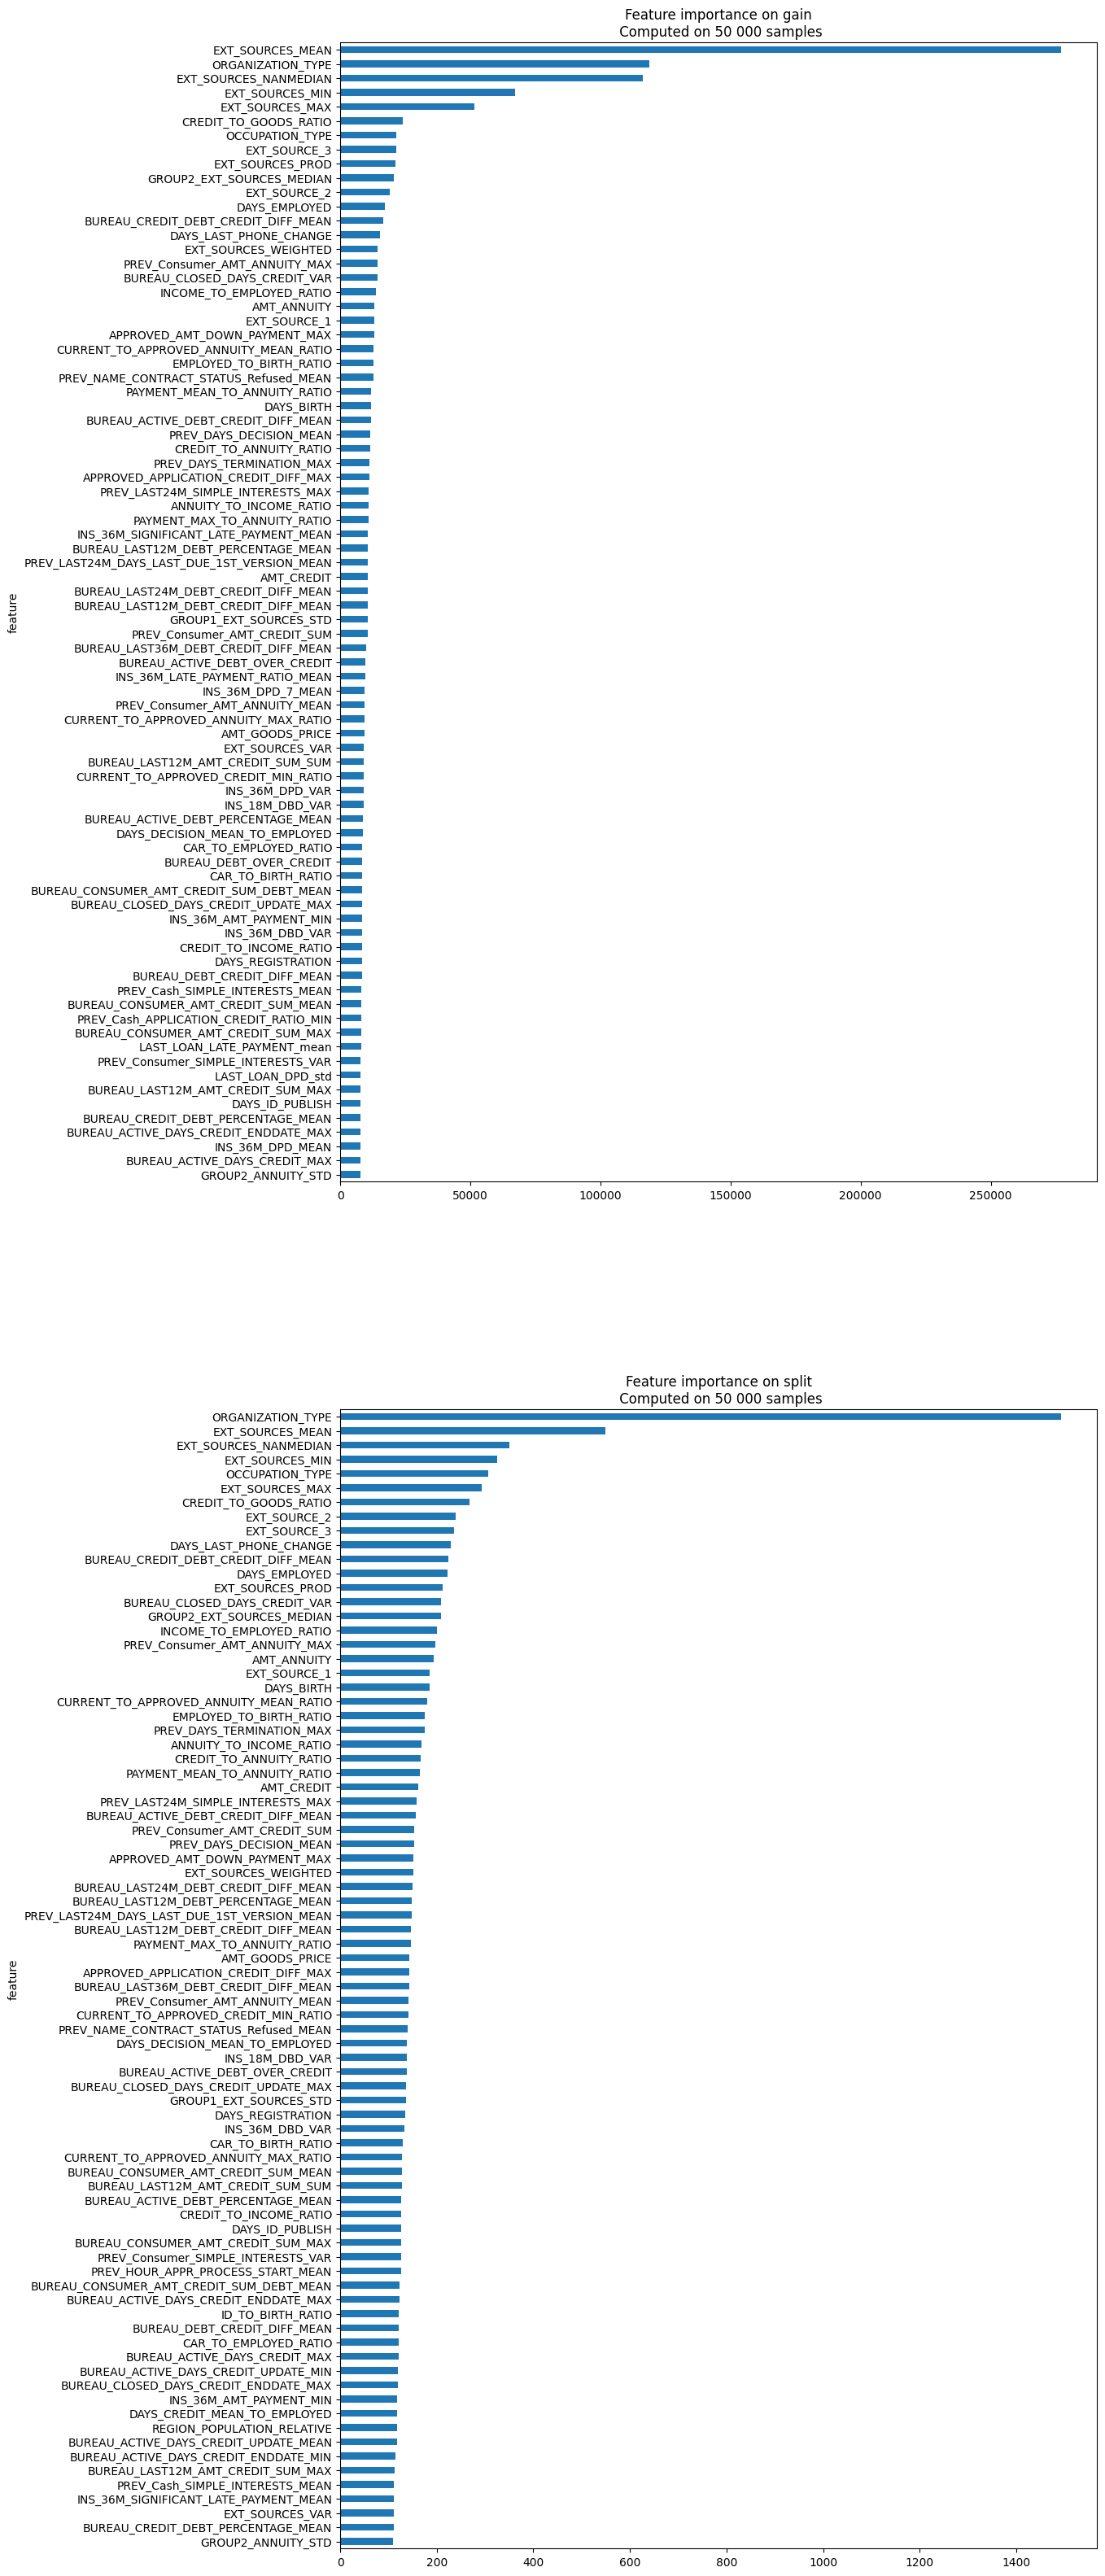

In [124]:
top_fts_gain, top_fts_split = display_feature_importance(mean_importance, n_fts=80)

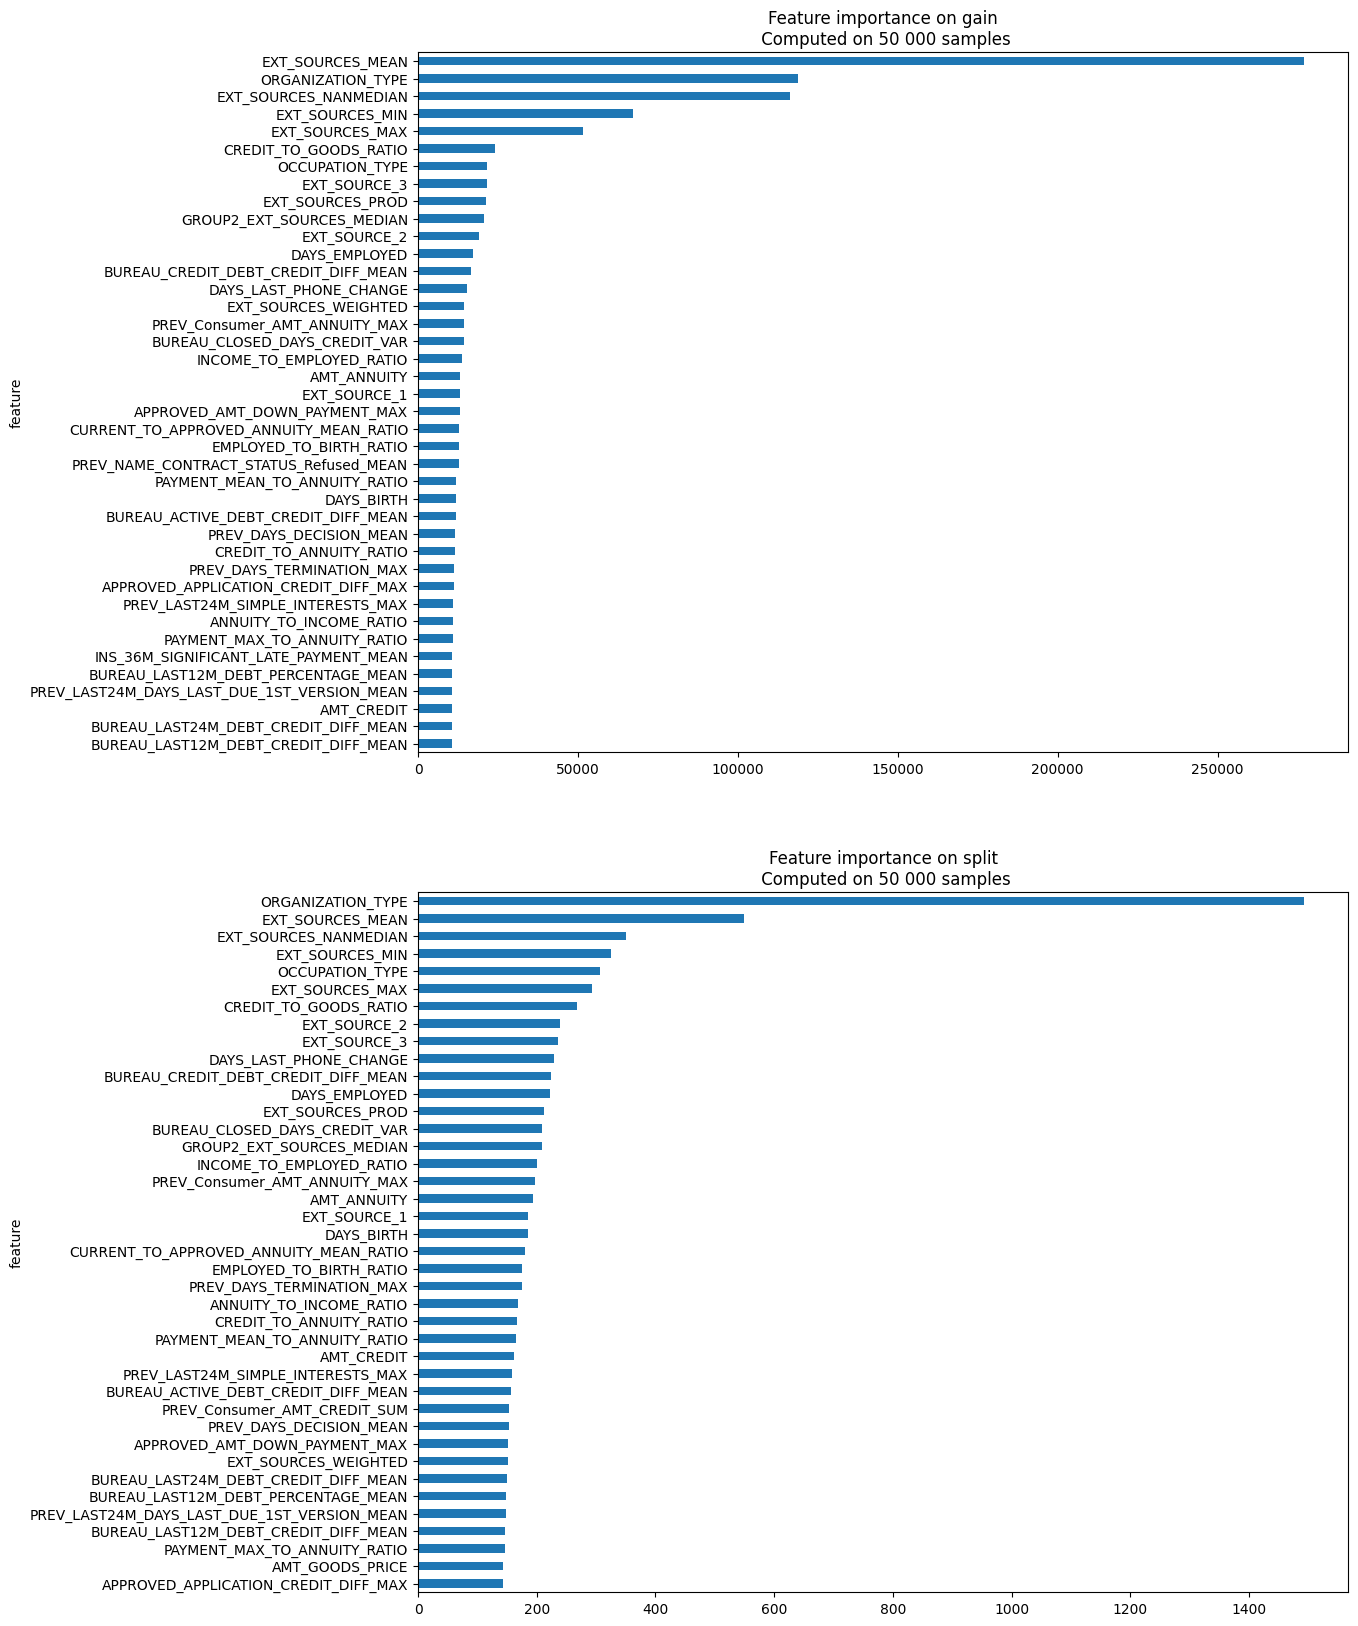

In [83]:
display_feature_importance(mean_importance, n_fts=40)

In [89]:
common_fts = [ft for ft in top_fts_gain if ft in top_fts_split]
display(common_fts)
print(len(common_fts))

['GROUP2_ANNUITY_STD',
 'BUREAU_ACTIVE_DAYS_CREDIT_MAX',
 'BUREAU_ACTIVE_DAYS_CREDIT_ENDDATE_MAX',
 'BUREAU_CREDIT_DEBT_PERCENTAGE_MEAN',
 'DAYS_ID_PUBLISH',
 'BUREAU_LAST12M_AMT_CREDIT_SUM_MAX',
 'PREV_Consumer_SIMPLE_INTERESTS_VAR',
 'BUREAU_CONSUMER_AMT_CREDIT_SUM_MAX',
 'BUREAU_CONSUMER_AMT_CREDIT_SUM_MEAN',
 'PREV_Cash_SIMPLE_INTERESTS_MEAN',
 'BUREAU_DEBT_CREDIT_DIFF_MEAN',
 'DAYS_REGISTRATION',
 'CREDIT_TO_INCOME_RATIO',
 'INS_36M_DBD_VAR',
 'INS_36M_AMT_PAYMENT_MIN',
 'BUREAU_CLOSED_DAYS_CREDIT_UPDATE_MAX',
 'BUREAU_CONSUMER_AMT_CREDIT_SUM_DEBT_MEAN',
 'CAR_TO_BIRTH_RATIO',
 'CAR_TO_EMPLOYED_RATIO',
 'DAYS_DECISION_MEAN_TO_EMPLOYED',
 'BUREAU_ACTIVE_DEBT_PERCENTAGE_MEAN',
 'INS_18M_DBD_VAR',
 'CURRENT_TO_APPROVED_CREDIT_MIN_RATIO',
 'BUREAU_LAST12M_AMT_CREDIT_SUM_SUM',
 'EXT_SOURCES_VAR',
 'AMT_GOODS_PRICE',
 'CURRENT_TO_APPROVED_ANNUITY_MAX_RATIO',
 'PREV_Consumer_AMT_ANNUITY_MEAN',
 'BUREAU_ACTIVE_DEBT_OVER_CREDIT',
 'BUREAU_LAST36M_DEBT_CREDIT_DIFF_MEAN',
 'PREV_Consumer_AMT

72


In the top 80 of both feature importance (gain/split), 72 are common.

In [126]:
# get feature rank
top_fts_gain = pd.Series(top_fts_gain[::-1]).reset_index()
top_fts_split = pd.Series(top_fts_split[::-1]).reset_index()
top_fts_gain.head()

,index,0
0,0,EXT_SOURCES_MEAN
1,1,ORGANIZATION_TYPE
2,2,EXT_SOURCES_NANMEDIAN
3,3,EXT_SOURCES_MIN
4,4,EXT_SOURCES_MAX


In [133]:
# zip it to compare ranking
zip_df = top_fts_gain.merge(
    top_fts_split,
    on=0,
    how='outer',
    suffixes=("_gain", "_split")
).rename(columns={0: 'feature'}).set_index('feature')

# zip_df.pop("index_change")
zip_df['both_presence_top30'] = (zip_df <= 30)[['index_gain', 'index_split']].all(axis=1)
zip_df.sort_values('index_gain').head(30)

,index_gain,index_split,both_presence_top30
feature,,,
EXT_SOURCES_MEAN,0.0,1.0,True
ORGANIZATION_TYPE,1.0,0.0,True
EXT_SOURCES_NANMEDIAN,2.0,2.0,True
EXT_SOURCES_MIN,3.0,3.0,True
EXT_SOURCES_MAX,4.0,5.0,True
CREDIT_TO_GOODS_RATIO,5.0,6.0,True
OCCUPATION_TYPE,6.0,4.0,True
EXT_SOURCE_3,7.0,8.0,True
EXT_SOURCES_PROD,8.0,12.0,True


In [134]:
sel_fts = list(zip_df.query('both_presence_top30 ').index)
display(sel_fts)
len(sel_fts)

['EXT_SOURCES_MEAN',
 'ORGANIZATION_TYPE',
 'EXT_SOURCES_NANMEDIAN',
 'EXT_SOURCES_MIN',
 'EXT_SOURCES_MAX',
 'CREDIT_TO_GOODS_RATIO',
 'OCCUPATION_TYPE',
 'EXT_SOURCE_3',
 'EXT_SOURCES_PROD',
 'GROUP2_EXT_SOURCES_MEDIAN',
 'EXT_SOURCE_2',
 'DAYS_EMPLOYED',
 'BUREAU_CREDIT_DEBT_CREDIT_DIFF_MEAN',
 'DAYS_LAST_PHONE_CHANGE',
 'PREV_Consumer_AMT_ANNUITY_MAX',
 'BUREAU_CLOSED_DAYS_CREDIT_VAR',
 'INCOME_TO_EMPLOYED_RATIO',
 'AMT_ANNUITY',
 'EXT_SOURCE_1',
 'CURRENT_TO_APPROVED_ANNUITY_MEAN_RATIO',
 'EMPLOYED_TO_BIRTH_RATIO',
 'PAYMENT_MEAN_TO_ANNUITY_RATIO',
 'DAYS_BIRTH',
 'BUREAU_ACTIVE_DEBT_CREDIT_DIFF_MEAN',
 'PREV_DAYS_DECISION_MEAN',
 'CREDIT_TO_ANNUITY_RATIO',
 'PREV_DAYS_TERMINATION_MAX']

27

Among the top 30, 27 features are common to the split and gain importance. 

Some seem redundant. For example, ext_sourceN (n being 1,2 or 3) is already contained within (ext_sources_nanmedian, ext_sources_min, ext_sources_max) and could introduce colinearity problems.

But overall, we have a plausible nice feature selection.

In [4]:
sel_fts_intrinsic = [
    'EXT_SOURCES_MEAN',
    'ORGANIZATION_TYPE',
    'EXT_SOURCES_NANMEDIAN',
    'EXT_SOURCES_MIN',
    'EXT_SOURCES_MAX',
    'CREDIT_TO_GOODS_RATIO',
    'OCCUPATION_TYPE',
    'EXT_SOURCE_3',
    'EXT_SOURCES_PROD',
    'GROUP2_EXT_SOURCES_MEDIAN',
    'EXT_SOURCE_2',
    'DAYS_EMPLOYED',
    'BUREAU_CREDIT_DEBT_CREDIT_DIFF_MEAN',
    'DAYS_LAST_PHONE_CHANGE',
    'PREV_Consumer_AMT_ANNUITY_MAX',
    'BUREAU_CLOSED_DAYS_CREDIT_VAR',
    'INCOME_TO_EMPLOYED_RATIO',
    'AMT_ANNUITY',
    'EXT_SOURCE_1',
    'CURRENT_TO_APPROVED_ANNUITY_MEAN_RATIO',
    'EMPLOYED_TO_BIRTH_RATIO',
    'PAYMENT_MEAN_TO_ANNUITY_RATIO',
    'DAYS_BIRTH',
    'BUREAU_ACTIVE_DEBT_CREDIT_DIFF_MEAN',
    'PREV_DAYS_DECISION_MEAN',
    'CREDIT_TO_ANNUITY_RATIO',
    'PREV_DAYS_TERMINATION_MAX'
]

# 7.  [&#9650;](#toc0_) <a id='toc7_'></a>Imputing selected features

In [79]:
# Get the features and target of individuals with a target.
X, y = utils.prepare_data(
    config.FEATURE_PATH,
    drop_INF=False,
    drop_NAN=False,
)

Data shape: (307506, 735), target shape: (307506,)


## 7.1.  [&#9650;](#toc0_) <a id='toc7_1_'></a>EDA

In [81]:
pd.options.display.max_columns = 50
X = X[sel_fts_intrinsic]
X.describe()

,EXT_SOURCES_MEAN,ORGANIZATION_TYPE,EXT_SOURCES_NANMEDIAN,EXT_SOURCES_MIN,EXT_SOURCES_MAX,CREDIT_TO_GOODS_RATIO,OCCUPATION_TYPE,EXT_SOURCE_3,EXT_SOURCES_PROD,GROUP2_EXT_SOURCES_MEDIAN,EXT_SOURCE_2,DAYS_EMPLOYED,BUREAU_CREDIT_DEBT_CREDIT_DIFF_MEAN,DAYS_LAST_PHONE_CHANGE,PREV_Consumer_AMT_ANNUITY_MAX,BUREAU_CLOSED_DAYS_CREDIT_VAR,INCOME_TO_EMPLOYED_RATIO,AMT_ANNUITY,EXT_SOURCE_1,CURRENT_TO_APPROVED_ANNUITY_MEAN_RATIO,EMPLOYED_TO_BIRTH_RATIO,PAYMENT_MEAN_TO_ANNUITY_RATIO,DAYS_BIRTH,BUREAU_ACTIVE_DEBT_CREDIT_DIFF_MEAN,PREV_DAYS_DECISION_MEAN,CREDIT_TO_ANNUITY_RATIO,PREV_DAYS_TERMINATION_MAX
count,307334.000000,307506.000000,307334.000000,3.073340e+05,307334.000000,307228.000000,307506.000000,246541.000000,1.095860e+05,307506.000000,3.068460e+05,252132.0,1.610660e+05,269834.0,268039.000000,1.766560e+05,2.521320e+05,307494.000000,134130.000000,290046.000000,252132.000000,291618.000000,307506.000000,2.065080e+05,291052.00,307494.000000,267009.0
mean,NaN,9.546441,NaN,NaN,NaN,NaN,2.280502,NaN,0.000000e+00,NaN,NaN,NaN,9.288435e+04,NaN,12781.461914,4.319622e+05,inf,27108.671875,NaN,0.628221,0.000000,0.833246,-16037.038399,1.630772e+05,NaN,NaN,NaN
std,0.000000,10.845966,0.000000,0.000000e+00,0.000000,0.000000,3.830320,0.000000,0.000000e+00,0.000000,0.000000e+00,NaN,1.612663e+05,NaN,9679.233398,4.357628e+05,NaN,14493.821289,0.000000,0.523466,0.000000,1.222393,4363.985156,4.360088e+05,NaN,0.000000,NaN
min,0.000006,0.000000,0.000006,5.960464e-08,0.000006,0.150024,-1.000000,0.000527,2.384186e-07,0.042450,5.960464e-08,-17920.0,-4.389052e+06,-4292.0,579.780029,0.000000e+00,-2.137500e+05,1615.500000,0.014565,0.000000,-0.000000,0.000009,-25229.000000,-2.044161e+07,-2922.00,8.039062,-2852.0
25%,0.413574,1.000000,0.409668,2.539062e-01,0.540527,1.000000,-1.000000,0.370605,5.612183e-02,0.487549,3.925781e-01,-3176.0,1.086750e+04,-1660.0,6791.759766,9.916637e+04,-2.173621e+02,16524.000000,0.333984,0.300252,0.056091,0.303639,-19682.000000,2.940187e+04,-1247.00,15.617188,-710.0
50%,0.524414,5.000000,0.532227,4.030762e-01,0.648438,1.119141,1.000000,0.535156,1.199341e-01,0.523926,5.659180e-01,-1648.0,5.499506e+04,-926.0,10535.219727,3.233200e+05,-9.717057e+01,24903.000000,0.505859,0.490380,0.118713,0.536876,-15750.000000,7.881044e+04,-789.00,20.000000,-337.0
75%,0.623047,12.000000,0.634277,5.532227e-01,0.725098,1.198242,5.000000,0.668945,2.100830e-01,0.547852,6.635742e-01,-767.0,1.337652e+05,-441.0,15672.105469,6.258532e+05,-4.734848e+01,34596.000000,0.675293,0.783734,0.219116,0.965311,-12413.000000,1.773052e+05,-466.75,27.093750,-154.0
max,0.878906,57.000000,0.885254,8.789062e-01,0.962891,6.000000,17.000000,0.895996,6.186523e-01,0.810547,8.549805e-01,0.0,3.463279e+07,-1.0,393868.656250,4.032800e+06,inf,258025.500000,0.962891,11.658400,0.729004,173.126328,-7489.000000,9.002801e+07,-2.00,45.312500,-2.0


INCOME_TO_EMPLOYED_RATIO exhibits some inf values.

In [82]:
inf_mask = ((X == np.inf) | (X ==-np.inf))
print(inf_mask.sum().sum())

2


We can remove those 2 individuals.

In [83]:
inf_mask = ((X == np.inf) | (X ==-np.inf)).any(axis=1)
X = X.loc[~inf_mask, :]
y = y[~inf_mask]

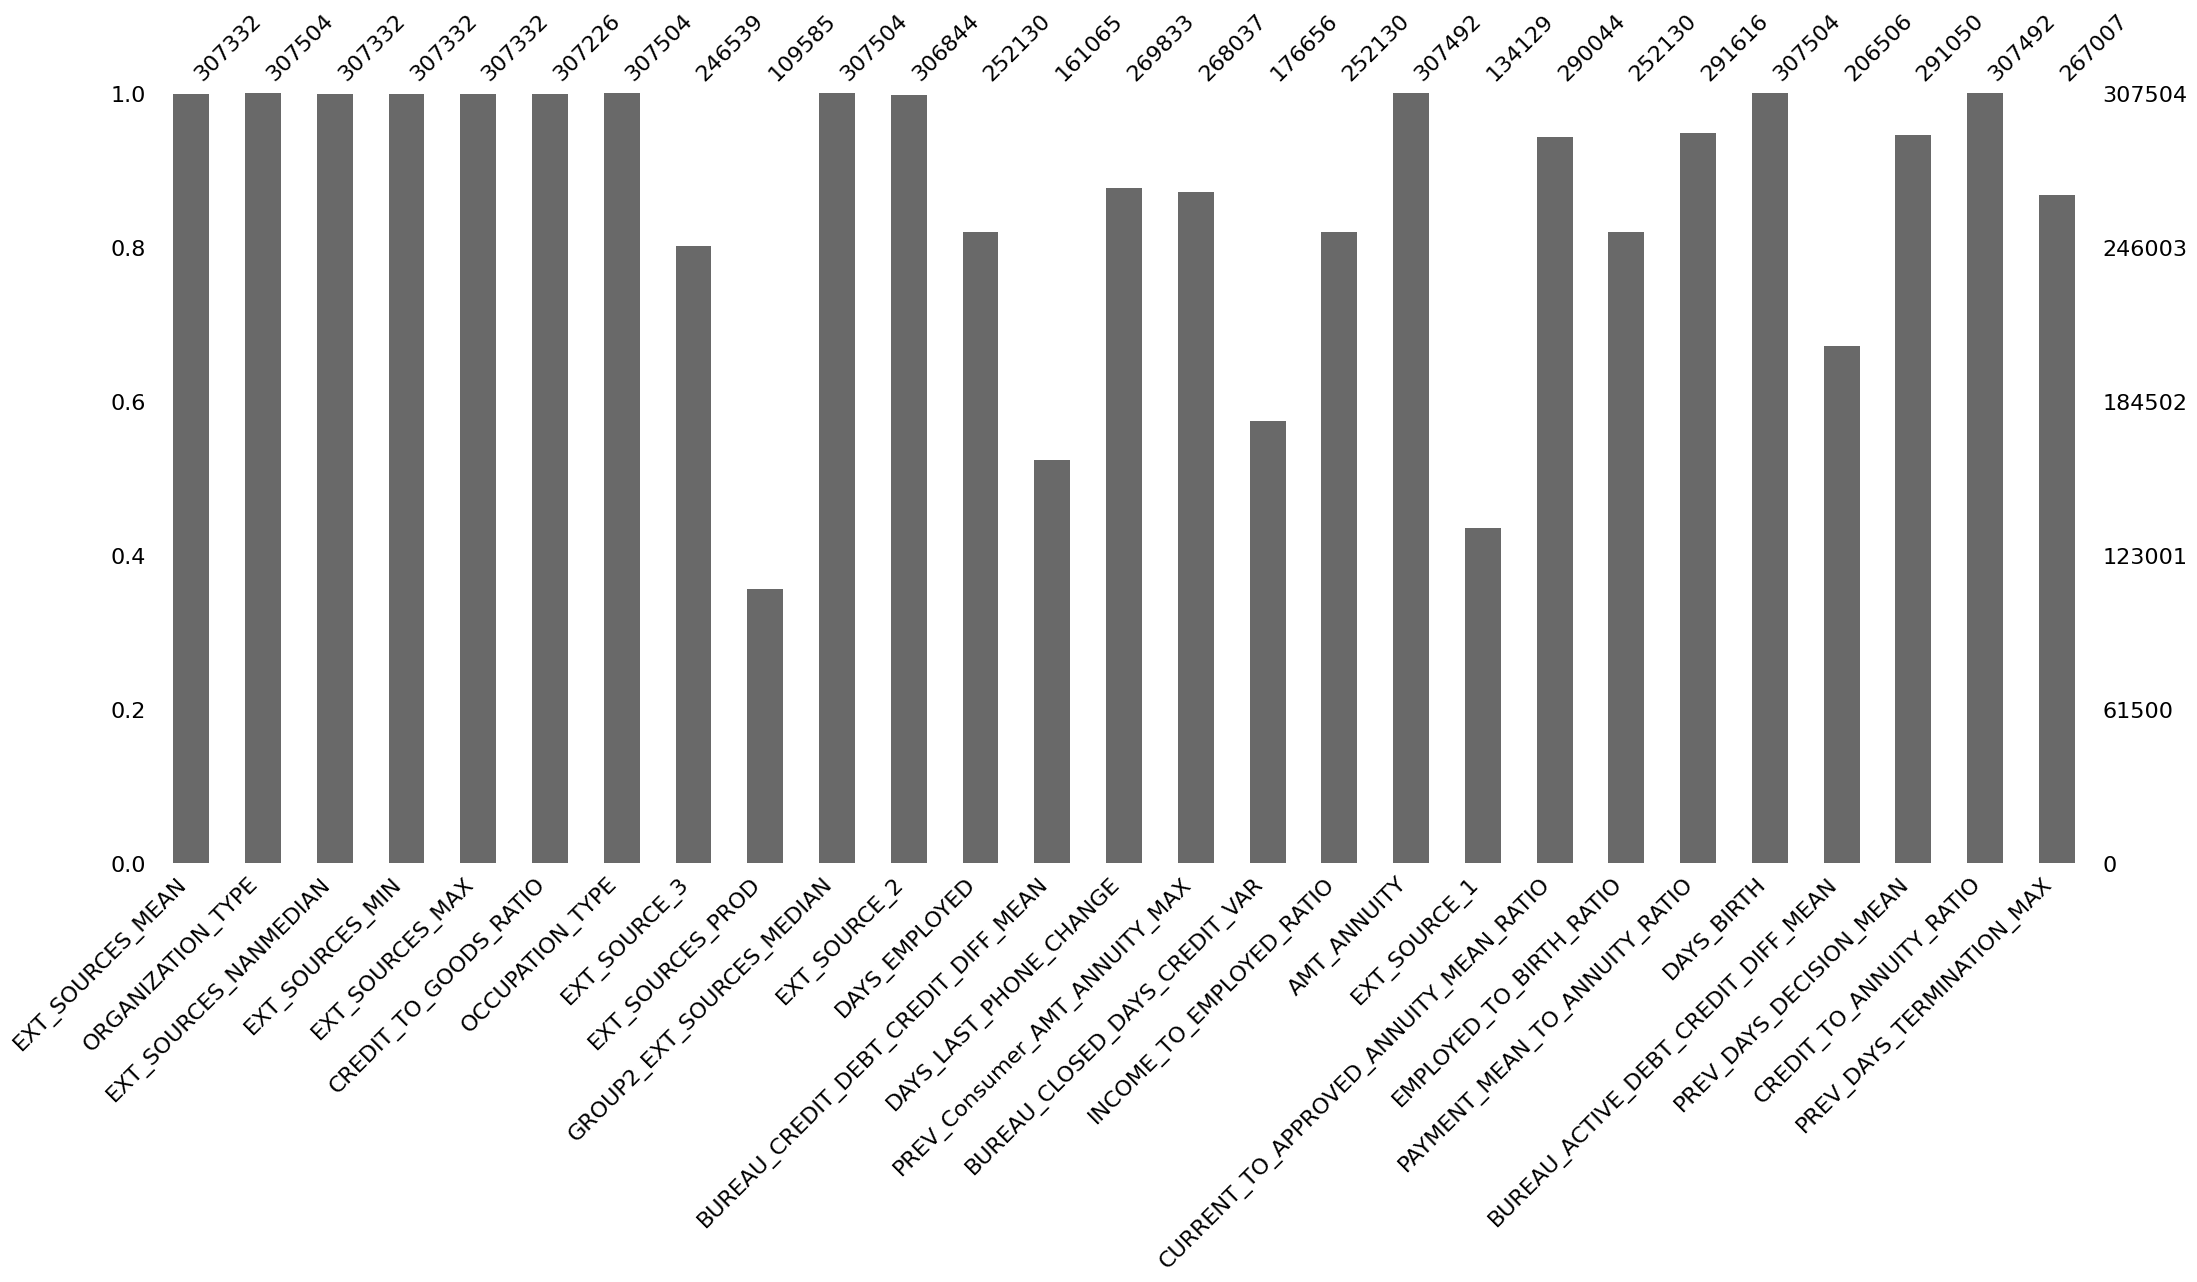

In [85]:
msno.bar(X)
plt.show()

EXT_SOURCE_1 has a lot of nulls. Consequently, ext_sources_prod also has.

ORGANIZATION_TYPE and OCCUPATION_TYPE are fully known.

As external sources play a great role in my selected features. I want to explore them.

But let's have a definition reminder before that.

In [64]:
# definition reminder
COLUMNS_DESCRIPTION_PATH = '../data/HomeCredit_columns_description.csv'
desc_df = pd.read_csv(
    COLUMNS_DESCRIPTION_PATH,
    index_col=0,
    encoding_errors='ignore',
)

df = desc_df.query('Row in @sel_fts_intrinsic')
for index, row in df.iterrows():
    print('{:>30} : {} '.format(row.Row, row.Description))


                   AMT_ANNUITY : Loan annuity 
                    DAYS_BIRTH : Client's age in days at the time of application 
                 DAYS_EMPLOYED : How many days before the application the person started current employment 
               OCCUPATION_TYPE : What kind of occupation does the client have 
             ORGANIZATION_TYPE : Type of organization where client works 
                  EXT_SOURCE_1 : Normalized score from external data source 
                  EXT_SOURCE_2 : Normalized score from external data source 
                  EXT_SOURCE_3 : Normalized score from external data source 
        DAYS_LAST_PHONE_CHANGE : How many days before application did client change phone 
                   AMT_ANNUITY : Annuity of the Credit Bureau credit 
                   AMT_ANNUITY : Annuity of previous application 


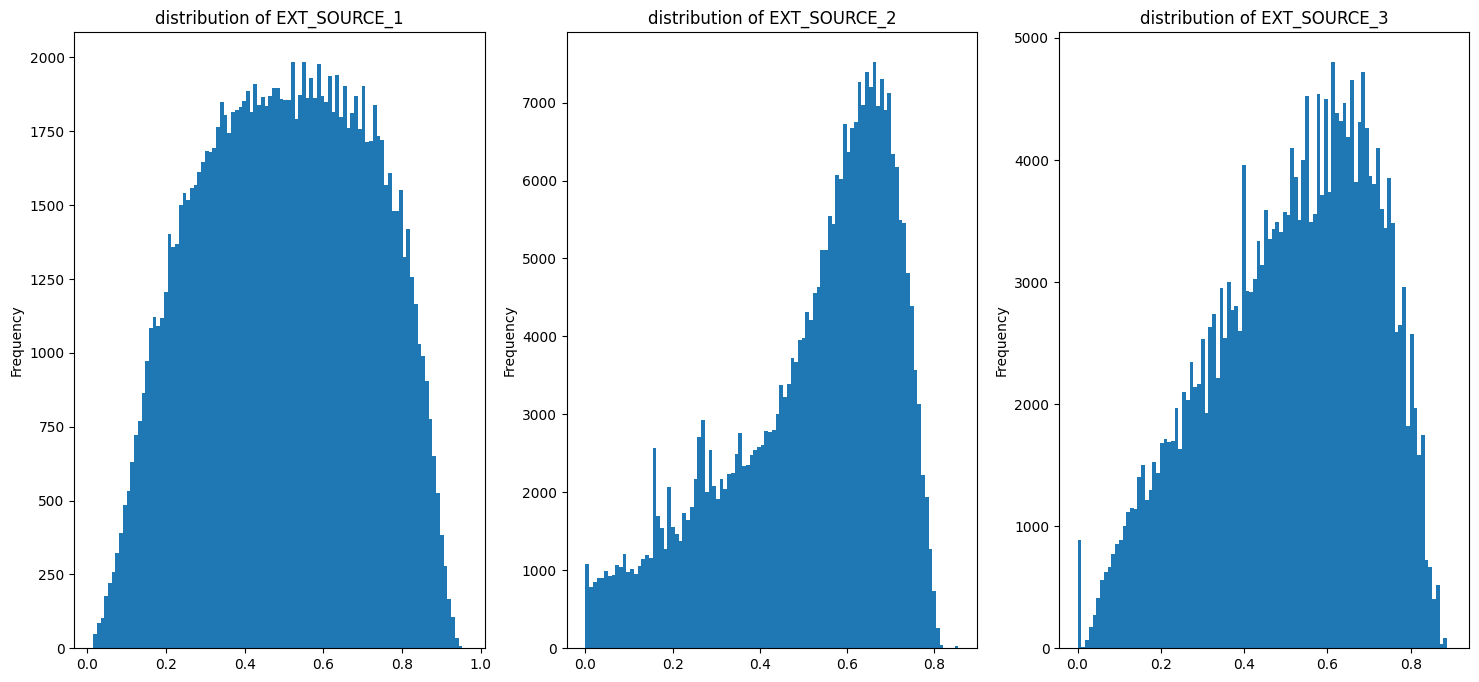

In [88]:
# plotting EXT_SOURCE's distributions
src1 = X.EXT_SOURCE_1
src2 = X.EXT_SOURCE_2
src3 = X.EXT_SOURCE_3
sources = [eval(f"src{i}") for i in range(1,4)]

fig, ax = plt.subplots(1, 3, figsize=(18,8))

for n, (ax, src) in enumerate(zip(ax.flat, sources)):
    src.plot(
        kind='hist',
        bins=100,
        ax=ax,
        title=f'distribution of EXT_SOURCE_{n+1}'
    )

plt.show()

/home/louberehc/.pyenv/versions/3.11.4/envs/p7/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/louberehc/.pyenv/versions/3.11.4/envs/p7/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/louberehc/.pyenv/versions/3.11.4/envs/p7/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


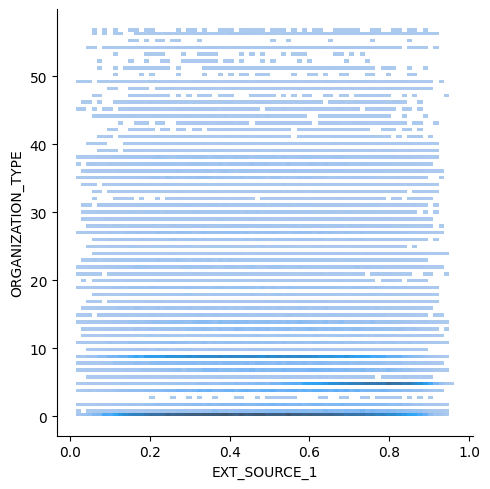

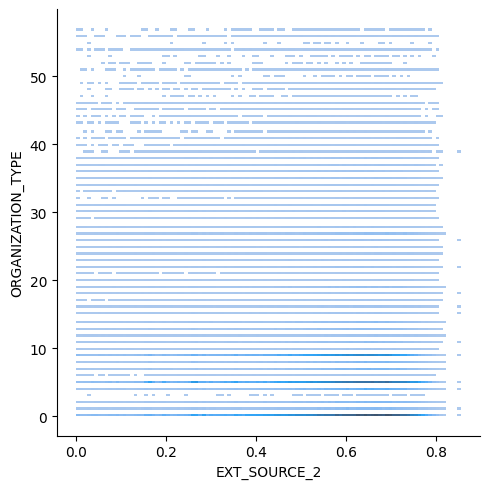

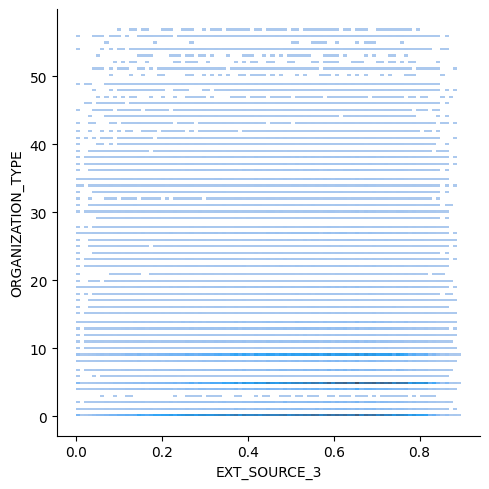

In [92]:
for n in range(3):
    sns.displot(X, x=f'EXT_SOURCE_{n+1}', y='ORGANIZATION_TYPE')

In [47]:
# number of nulls per individual, per class
df_ = X.isnull().sum(axis=1)
df_ = pd.concat([df_, y], axis=1).rename(columns={0: 'n_null_values'})
df_.head()

,n_null_values,TARGET
SK_ID_CURR,,
100002,0,1
100003,2,0
100004,4,0
100006,6,0
100007,6,0


/home/louberehc/.pyenv/versions/3.11.4/envs/p7/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


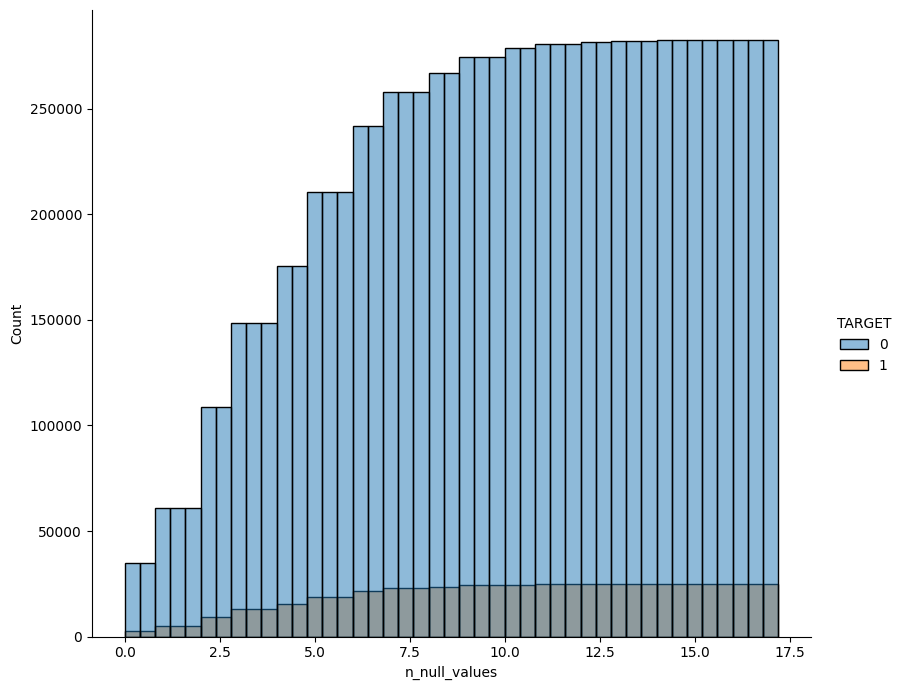

In [86]:
sns.displot(
    df_,
    kind='hist',
    x='n_null_values',
    hue='TARGET',
    height=7,
    aspect=1.2,
    binwidth=0.4,
    cumulative=True,
)
plt.show()

Very few individuals have more than 10 null_values, and they are not particularly in the minority class, so I can delete those individuals.

In [59]:
X.shape

(307506, 27)

In [61]:
X = X.loc[(df_.n_null_values < 10), :]
X.shape

(298903, 27)

<Axes: >

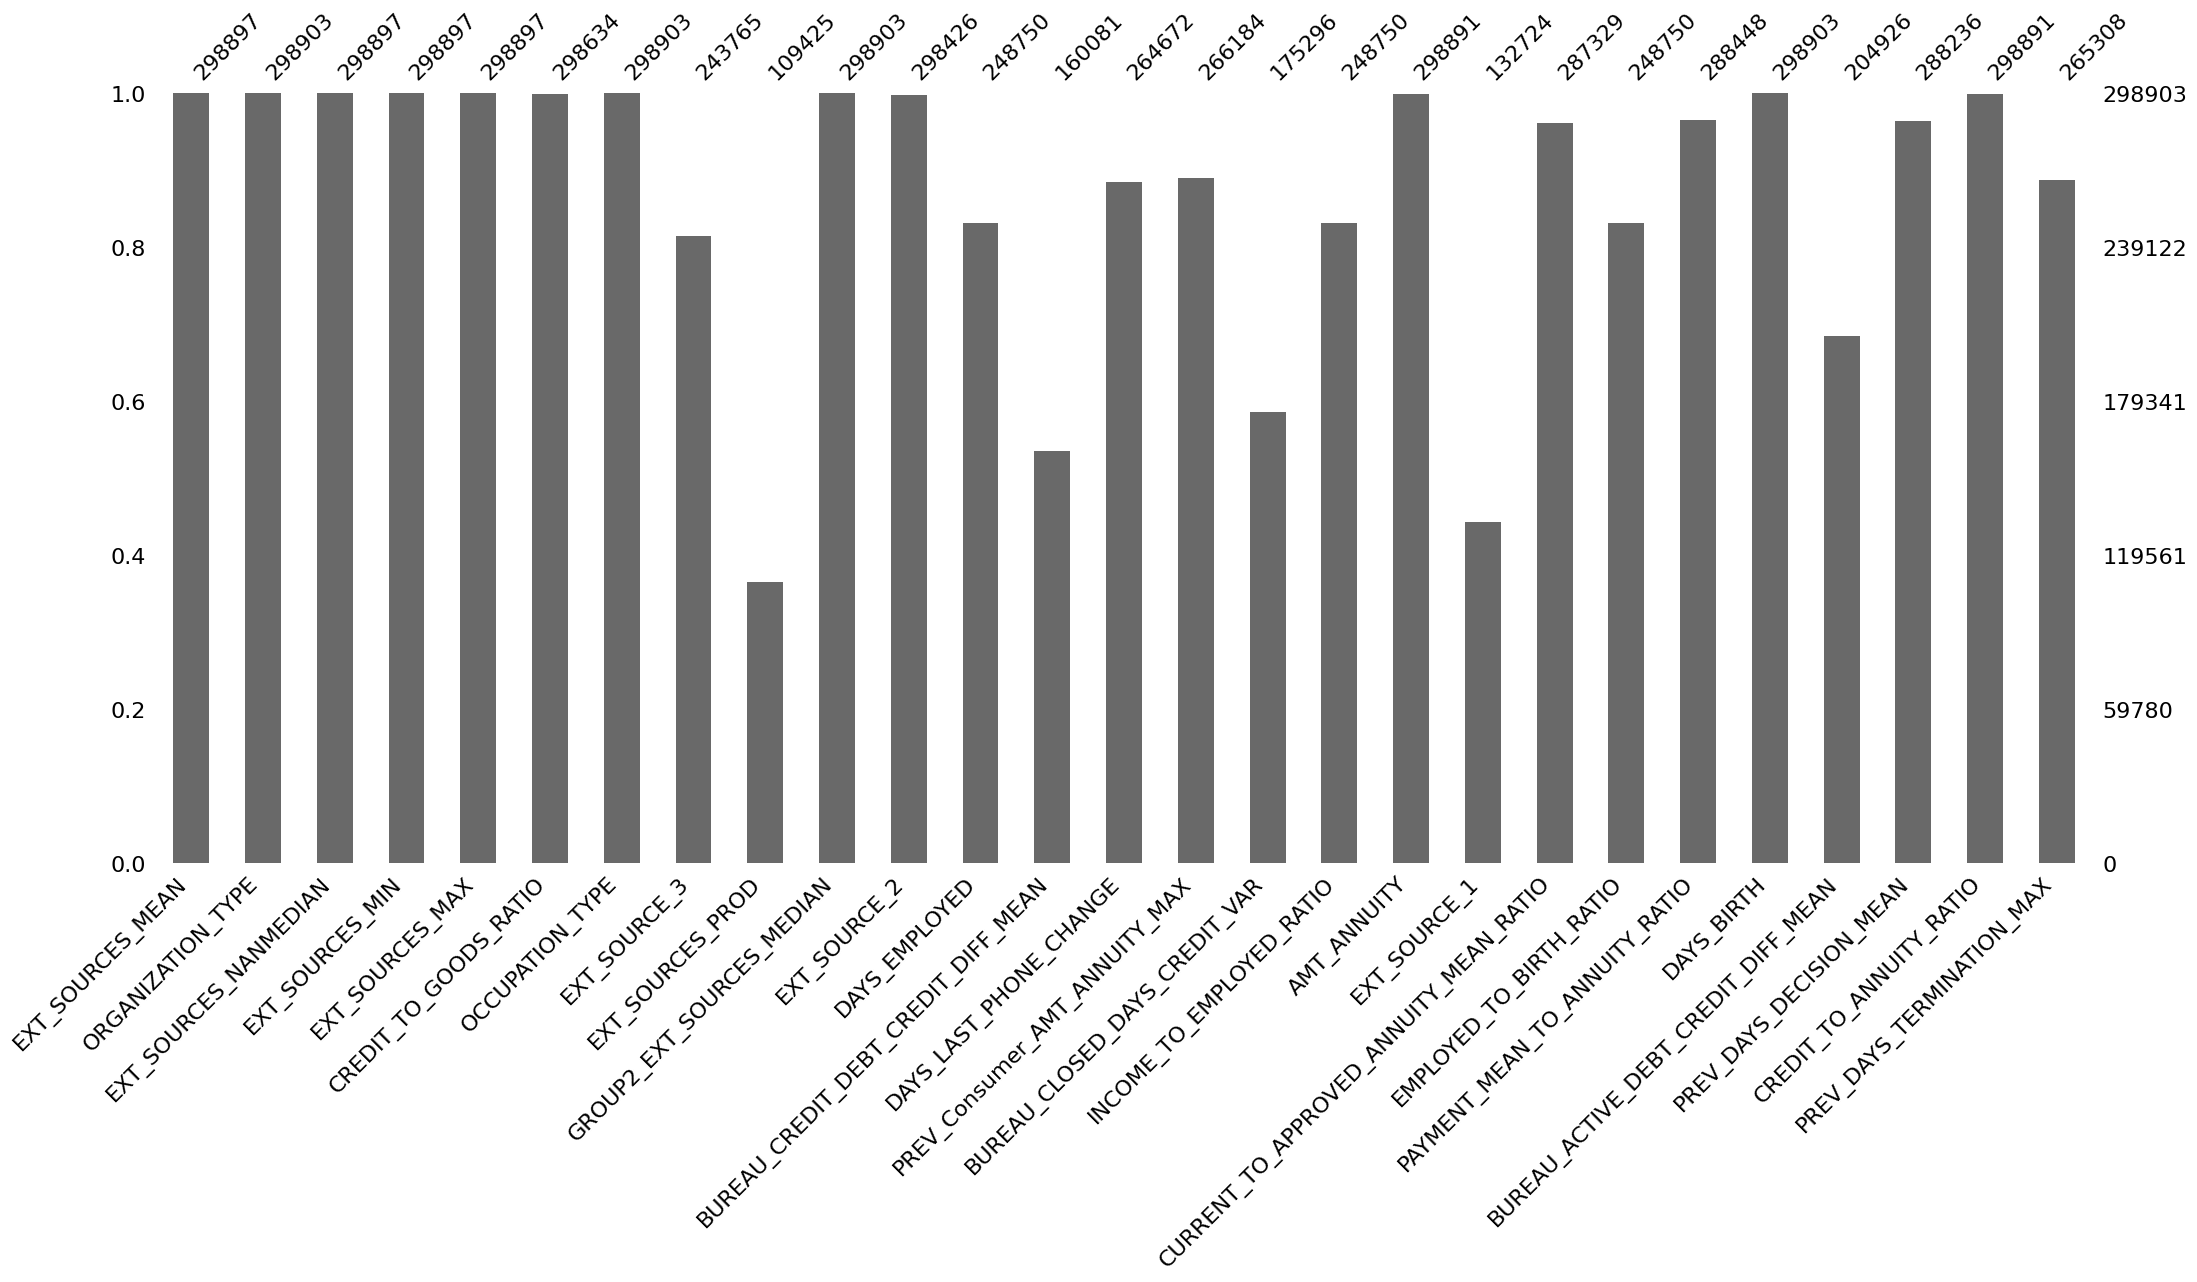

In [62]:
msno.bar(X)

# 8.  [&#9650;](#toc0_) <a id='toc8_'></a>Fine-tuning a classifier

see [this](https://towardsdatascience.com/fine-tuning-a-classifier-in-scikit-learn-66e048c21e65)

In [ ]:
scorers = {
    
}

In [ ]:

 
X = X .fillna(0)

lr = LogisticRegression() 
lr = lr.fit(X, y)
proba = lr.predict_proba(X)

print(proba[:100])    